In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from PIL import Image
import os
import re

In [23]:
# read in data, drop 'CLASS' column

data = pd.read_csv('CTG.csv')
data = data.drop(['CLASS'], axis=1)
data.head()

,LB,AC,FM,UC,ASTV,MSTV,ALTV,MLTV,DL,DS,...,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency,NSP
0,120,0,0,0,73,0.5,43,2.4,0,0,...,62,126,2,0,120,137,121,73,1,2
1,132,4,0,4,17,2.1,0,10.4,2,0,...,68,198,6,1,141,136,140,12,0,1
2,133,2,0,5,16,2.1,0,13.4,2,0,...,68,198,5,1,141,135,138,13,0,1
3,134,2,0,6,16,2.4,0,23.0,2,0,...,53,170,11,0,137,134,137,13,1,1
4,132,4,0,5,16,2.4,0,19.9,0,0,...,53,170,9,0,137,136,138,11,1,1


In [24]:
# randomize data, split into training and validation

data_np = data.to_numpy()
np.random.seed(0)
np.random.shuffle(data_np)

trainSplit = int(np.ceil(len(data_np) * (2/3)))
training, validation = data_np[:trainSplit], data_np[trainSplit:]
x_train, y_train = training[:, :-1], training[:, -1:]
x_valid, y_valid = validation[:, :-1], validation[:, -1:]

In [25]:
# function to calculate entropy

def entropy(data):
	counts = np.bincount(data).astype(int)
	probabilities = counts / len(data)
	entropy = -np.sum([p * np.log2(p) for p in probabilities if p > 0])
	return entropy

In [26]:
# function to split branches into left and right

def split(x_train, y_train, index, index_val):
    true_index = np.where(x_train[:, index] <= index_val)[0]
    false_index = np.where(x_train[:, index] > index_val)[0]

    true_xtrain, true_ytrain = x_train[true_index], y_train[true_index]
    false_xtrain, false_ytrain = x_train[false_index], y_train[false_index]

    return true_xtrain, true_ytrain, false_xtrain, false_ytrain

In [27]:
# function for decision tree

def make_tree(x_train, y_train):
    if len(set(y_train)) == 1:
        return y_train[0]
    
    num_features = x_train.shape[1]
    information_gain = 0
    branches = None
    feature_value = None

    current_entropy = entropy(y_train)

    for index in range(num_features):
        features = set(x_train[:, index])
        
        for index_val in features:
            true_xtrain, true_ytrain, false_xtrain, false_ytrain = split(x_train, y_train, index, index_val)
            true_entropy = entropy(true_ytrain)
            false_entropy = entropy(false_ytrain)
            
            proportion = len(true_ytrain) / len(y_train)

            entropy_loss = current_entropy - proportion * true_entropy - (1 - proportion) * false_entropy

            if entropy_loss > information_gain:
                information_gain = entropy_loss
                feature_value = (index, index_val)
                branches = (true_xtrain, true_ytrain, false_xtrain, false_ytrain)

    if information_gain > 0:
        true_branch = make_tree(branches[0], branches[1])
        false_branch = make_tree(branches[2], branches[3])
        return {
            'feature':       feature_value[0],
            'value':         feature_value[1], 
            'true_branch':   true_branch, 
            'false_branch':  false_branch }
    
    return max(set(y_train), key=list(y_train).count)

In [28]:
# function to predict values from decision tree

def predict(tree, sample):
    if not isinstance(tree, dict):
        return tree
    
    feature, value = tree['feature'], tree['value']

    if sample[feature] <= value:
        return predict(tree['true_branch'], sample)
    else:
        return predict(tree['false_branch'], sample)

In [29]:
# function to get predictions from decision tree

def myDT(x_train, y_train, x_valid):
    predictions = []
    y_train = y_train.ravel().astype(int)
    dt = make_tree(x_train, y_train)

    for i in range(len(x_valid)):
        predictions.append(predict(dt, x_valid[i]))

    return predictions

In [30]:
# function to calculate accuracy

def accuracy(predictions, true_value):

    correct = 0

    for i in range(len(predictions)):
        if predictions[i] == true_value[i]:
            correct += 1

    percentage_correct = (correct / len(predictions)) * 100

    return percentage_correct

In [31]:
predictions = myDT(x_train, y_train, x_valid)

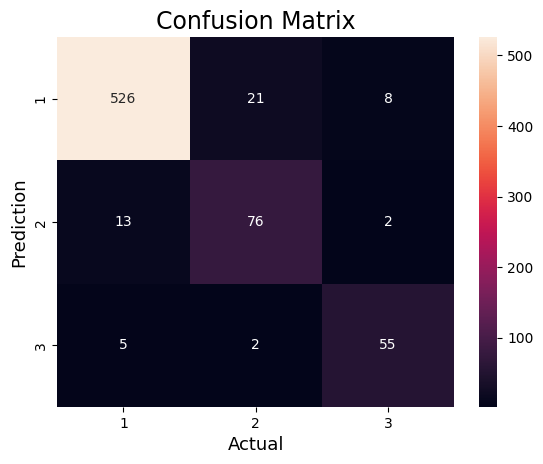

In [32]:
cm = confusion_matrix(y_valid, predictions)

sns.heatmap(cm,
            annot=True,
            fmt='g',
            xticklabels=[1, 2, 3],
            yticklabels=[1, 2, 3])
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()

In [33]:
# get accuracy for validation data

acc = accuracy(predictions, y_valid)
print('Validation Accuracy: {}%\n'.format(acc))

Validation Accuracy: 92.79661016949152%



In [34]:
path = os.getcwd() + '/yalefaces'
print('Current path: ' + os.getcwd())

Current path: /Users/matthewlucente/Desktop/snr szn/spring/cs383/5 - Decision Trees


In [35]:
# (1) Read the list of files

files = []

for (root, dirs, file) in os.walk(path):
    for f in file:
        files.append(os.path.join(root, f))

In [36]:
# (2) Read image, resize, flatten, concatenate to data matrix

rem = os.getcwd() + '/yalefaces/.DS_Store' # i am not sure why there was this file in here... 
if rem in files:
    files.remove(rem)

data_matrix = []

for i in files:
    image = Image.open(i)
    resized = image.resize((40,40))
    flattened = np.array(resized).flatten()
    data_matrix.append(flattened)

data_matrix = np.array(data_matrix)

In [37]:
# Extract and convert the subject numbers

extracted_numbers = []
for path in files:
    match = re.search(r'subject(\d+)\.', path)
    if match:
        try:
            number = int(match.group(1))
            extracted_numbers.append(number)
        except ValueError:
            extracted_numbers.append(None) 
    else:
        extracted_numbers.append(None)

target_val = np.array(extracted_numbers).reshape(-1,1)

In [38]:
data = np.concatenate((data_matrix, target_val), axis=1)
data.shape

(154, 1601)

In [39]:
# randomize data, split into training and validation

np.random.seed(0)
np.random.shuffle(data)

trainSplit = int(np.ceil(len(data) * (2/3)))
training, validation = data[:trainSplit], data[trainSplit:]
x_train, y_train = training[:, :-1], training[:, -1:]
x_valid, y_valid = validation[:, :-1], validation[:, -1:]

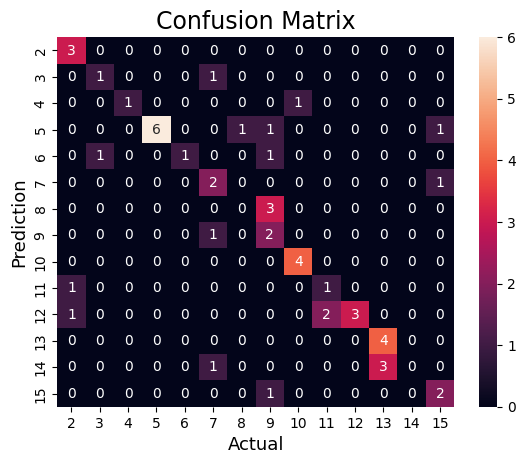

In [40]:
# get predictions for the yalefaces dataset and show confusion matrix

yale_pred = myDT(x_train, y_train, x_valid)
yp = np.atleast_2d(yale_pred).reshape(-1,1)
cm = confusion_matrix(y_valid, yp)

sns.heatmap(cm,
            annot=True,
            fmt='g',
            xticklabels=[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
            yticklabels=[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15])
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()

In [41]:
# get accuracy for validation data

acc = accuracy(yale_pred, y_valid)
print('Validation Accuracy: {}%\n'.format(acc))

Validation Accuracy: 58.82352941176471%

